In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2, os, glob, re, torch, random, time
import numpy as np
import imgaug
from imgaug import augmenters
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [169]:
img = torch.ones(500, 500, 3).long() * 255
prior = torch.tensor([[100, 100, 340, 340]]).float() / 500
reg = torch.tensor([[120, 120, 360, 300]]).float()/ 500

In [159]:
def center_conv_point(bboxes, kernel_size=3, c_min=0, c_max=1):
    """In a parallel manner also keeps the gradient during BP"""
    bboxes.clamp_(min=c_min, max=c_max)
    ratios = (bboxes[:, 2] - bboxes[:, 0]) / (bboxes[:, 3] - bboxes[:, 1])
    max_length = torch.max(torch.stack(((bboxes[:, 2] - bboxes[:, 0]), (bboxes[:, 3] - bboxes[:, 1])), dim=1), dim=1)[0]
    #print("ratios")
    #print(ratios)
    #print(max_length)
    # ratios计算方法为宽高比，所以small_idx代表比较高的box
    small_idx = ratios < 1
    one_idx = (ratios >= 0.9) * (ratios <= 1.1)
    # 将ratios中所有小于1的index取倒数
    ratios[small_idx] = 1 / ratios[small_idx]
    #offsets = ratios / (kernel_size ** 2)
    #offsets = (torch.tanh(0.3 * (ratios - 5)) / 2 + 0.5) * max_length / (kernel_size ** 2)
    offsets = torch.tanh(0.25 * ratios) * max_length / (kernel_size ** 2)
    offsets[one_idx] = 0
    offsets = offsets.unsqueeze(-1).repeat(1, 2 * kernel_size ** 2)
    #print("offsets")
    #print(offsets)

    assert kernel_size == 3, "下方的偏移量是为kernel size为3时设计的"
    distortion = torch.FloatTensor([-1, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]).cuda(bboxes.device.index)
    distortion2 = distortion.view(kernel_size, kernel_size, 2).permute(1, 0, 2)[:, :, (1, 0)].contiguous().view(-1)
    distortions = distortion.unsqueeze(0).repeat(bboxes.size(0), 1)
    distortions[small_idx] = distortion2
    distortions = distortions * offsets
    #print("distortions")
    #print(distortions)
    
    noise = torch.randn(distortions.size(0)) < 0
    # 产生随机偏移方向。如果box较高，左侧的centroid会向上也会向下偏移（右侧与左侧相反）
    # 如果box较宽，上方的点会向左或向右偏移（上方与下方偏移方向相反）
    distortions[noise] = distortions[noise] * -1
    #print(distortions)

    base = torch.cat([bboxes[:, :2]] * (kernel_size ** 2), dim=1)
    multiplier = torch.tensor([(2 * i + 1) / kernel_size / 2
                               for i in range(kernel_size)]).cuda(bboxes.device.index)
    multiplier = torch.stack(torch.meshgrid([multiplier, multiplier]),
                             dim=-1)[:, :, (1, 0)].contiguous().view(-1)
    multiplier = multiplier.unsqueeze(0).repeat(bboxes.size(0), 1)
    center = torch.stack([bboxes[:, 2] - bboxes[:, 0], bboxes[:, 3] - bboxes[:, 1]],
                         dim=-1)
    center = torch.cat([center] * (kernel_size ** 2), dim=1)
    centeroids = base + center * multiplier
    #print("centeroids")
    #print(centeroids)
    centeroids = centeroids + distortions
    #print(centeroids)
    return centeroids
    #return centeroids + centeroids * distortions

tensor([[195.7132, 180.0000, 235.7132, 180.0000, 275.7132, 180.0000, 200.0000,
         210.0000, 240.0000, 210.0000, 280.0000, 210.0000, 204.2868, 240.0000,
         244.2868, 240.0000, 284.2868, 240.0000]])


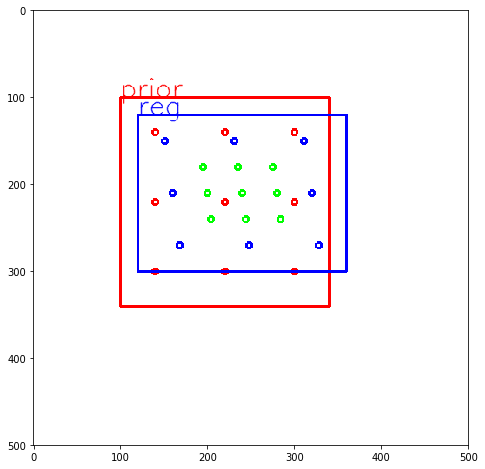

In [170]:
def plot_box(image, prior_box, reg_box):
    image = image.data.cpu().numpy().astype("uint8").copy()
    
    # get prior box and its inter conv points
    prior_conv_center = center_conv_point(prior_box, c_max=1) * 500
    # Draw conv center
    for coord in prior_conv_center.view(-1, 2):
        cv2.circle(image, (int(coord[0]), int(coord[1])), 3, (255, 0, 0), 2)
    prior_box = prior_box.data.cpu().numpy() * 500
    
    # get regressed box and its regress conv points
    reg_conv_center = center_conv_point(reg_box, c_max=1) * 500
    median = int(reg_conv_center.size(1) / 2)
    median = reg_conv_center[:, median-1:median+1].repeat(1, 9)
    residual = reg_conv_center - median
    median = (median + residual * 0.5).clamp(min=0, max=500)
    print(median)
            
    for coord in reg_conv_center.view(-1, 2):
        cv2.circle(image, (int(coord[0]), int(coord[1])), 3, (0, 0, 255), 2)
        
    for coord in median.view(-1, 2):
        cv2.circle(image, (int(coord[0]), int(coord[1])), 3, (0, 255, 0), 2)
    reg_box = reg_box.data.cpu().numpy() * 500
    
    # Draw the box out
    x1, y1, x2, y2 = prior_box[0]
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(image,'prior',(x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 0),1,cv2.LINE_AA)
    x1, y1, x2, y2 = reg_box[0]
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(image,'reg',(x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 0, 255),1,cv2.LINE_AA)
    plt.imshow(image)
    return prior_conv_center, reg_conv_center
plt.rcParams['figure.figsize'] = [8, 8]
prior_conv_center, reg_conv_center = plot_box(img, prior, reg)
deformation_map = reg_conv_center - prior_conv_center

In [ ]:
kernel_size = 3
n_sample = 1024
base = torch.randn(n_sample, 2).clamp(min=0, max=0.5)
bboxes = torch.cat([base, base + torch.randn(n_sample, 2).clamp(min=0.1, max=0.5)], dim=1).contiguous().cuda()
print("Ground truth:")
print(center_conv_point_vanilla(bboxes))
print("")
print("Parallel:")
print(center_conv_point_parallel(bboxes))

torch.sum(center_conv_point_parallel(bboxes) - center_conv_point_vanilla(bboxes).cuda())

In [ ]:
p = torch.tensor([[0.0133, 0.0133, 0.1000, 0.1000]])
center_conv_point_parallel(p)

In [ ]:
best_prior_idx = torch.tensor([3, 3, 0, 1, 7, 7])
best_truth_idx = torch.tensor([2, 3, 1, 0, 3, 4, 0, 5])

In [ ]:
best_truth_idx[best_prior_idx] = torch.arange(best_prior_idx.size(0))
best_truth_idx

In [ ]:
for j in range(best_prior_idx.size(0)):
    best_truth_idx[best_prior_idx[j]] = j
best_truth_idx

In [ ]:
torch.randn(10) < 0

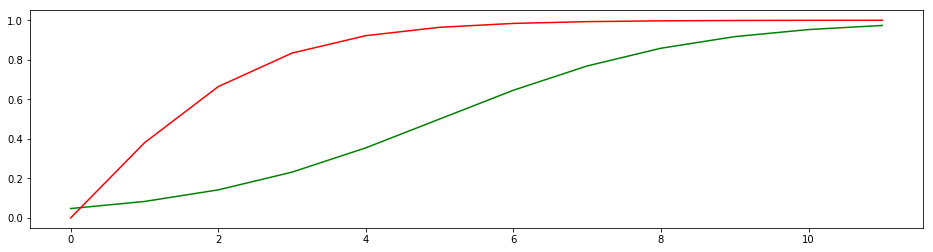

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[0.04742587 0.0831727  0.14185106 0.23147522 0.35434369 0.5
 0.64565631 0.76852478 0.85814894 0.9168273  0.95257413 0.97340301]


In [153]:
# evenly sampled time at 200ms intervals
plt.rcParams['figure.figsize'] = [16, 4]
t = np.arange(0., 12., 1)
y1 = np.tanh(0.3 * (t - 5)) / 2 + 0.5
y2 = np.tanh(0.4 * t)
# red dashes, blue squares and green triangles
#plt.plot(t, t, 'r-', t, y, 'g-', t, t, 'b-')
plt.plot(t, y1, 'g-', t, y2, 'r-')
plt.show()
print(t)
print(y)